# Reproducibility of key findings across individual batches

Our MERFISH dataset (coronal aging) was collected across two equally sized batches (different animals, ~8 months apart, different experiments with some technical differences).

This notebooks runs and confirms batch-separated versions of some key results in the manuscript:
- Cell type proportion changes during aging
- Spatial aging clock performance
- Rejuvenation/deleterious intervention effects
- Cell proximity effects of aging

**Associated manuscript figures/tables:**
- Extended Data Figures: 5i; 9g,h


**Inputs required:**
- `results/clocks/batchA_lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20_*.pkl` - pickle files containing sklearn Pipeline objects of spatial aging clocks (generated from `full_train_clock_batched.py`)
- `results/clocks/batchB_lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20_*.pkl` - pickle files containing sklearn Pipeline objects of spatial aging clocks (generated from `full_train_clock_batched.py`)
- `results/clocks/anndata/batchA_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad` - AnnData object for coronal sections data with spatial aging clock predictions (generated from `cv_train_clock_batched.py`)
- `results/clocks/anndata/batchB_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad` - AnnData object for coronal sections data with spatial aging clock predictions (generated from `cv_train_clock_batched.py`)
- `data/integrated_aging_coronal_celltyped_regioned_raw.h5ad` - AnnData object for coronal sections dataset
- `data/integrated_exercise_coronal_celltyped_regioned_raw.h5ad` - AnnData object for exercise dataset
- `data/integrated_reprogramming_coronal_celltyped_regioned_raw.h5ad` - AnnData object for reprogramming dataset
- assorted AnnData objects corresponding to external datasets from Allen et al. (2022), Zeng et al. (2023), Androvic et al. (2023), Kukanja et al. (2024) and reformatted according to steps in Methods section of manuscript 

**Conda environment used**: `requirements/merfish.txt`

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
from scipy.stats import pearsonr, spearmanr, ttest_ind
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style("ticks")
from sklearn.neighbors import BallTree
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, LassoCV, lasso_path, LinearRegression
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors

from scipy.stats import mannwhitneyu, ttest_ind
from statsmodels.stats.multitest import multipletests
from decimal import Decimal

from ageaccel_proximity import *
from clock_preprocessing import *
from clock_prediction import *

In [2]:
restricted_celltype_subset = ['Neuron-Excitatory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','Ependymal','Neuroblast','NSC','Macrophage', 'T cell']

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']


celltype_palette = {'Neuron-Excitatory':'forestgreen',
                    'Neuron-Inhibitory':'lightgreen', 
                    'Neuron-MSN':'yellowgreen',
                    'Astrocyte': 'royalblue', 
                    'Microglia': 'aqua', 
                    'Oligodendrocyte': 'skyblue', 
                    'OPC': 'deepskyblue',
                    'Endothelial': 'red', 
                    'Pericyte': 'darkred', 
                    'VSMC': 'salmon', 
                    'VLMC': 'indianred',
                    'Ependymal': 'gray', 
                    'Neuroblast': 'sandybrown', 
                    'NSC':'darkorange', 
                    'Macrophage':'purple', 
                    'Neutrophil':'darkviolet',
                    'T cell':'magenta', 
                    'B cell':'orchid',
}

## Spatial aging clock performance

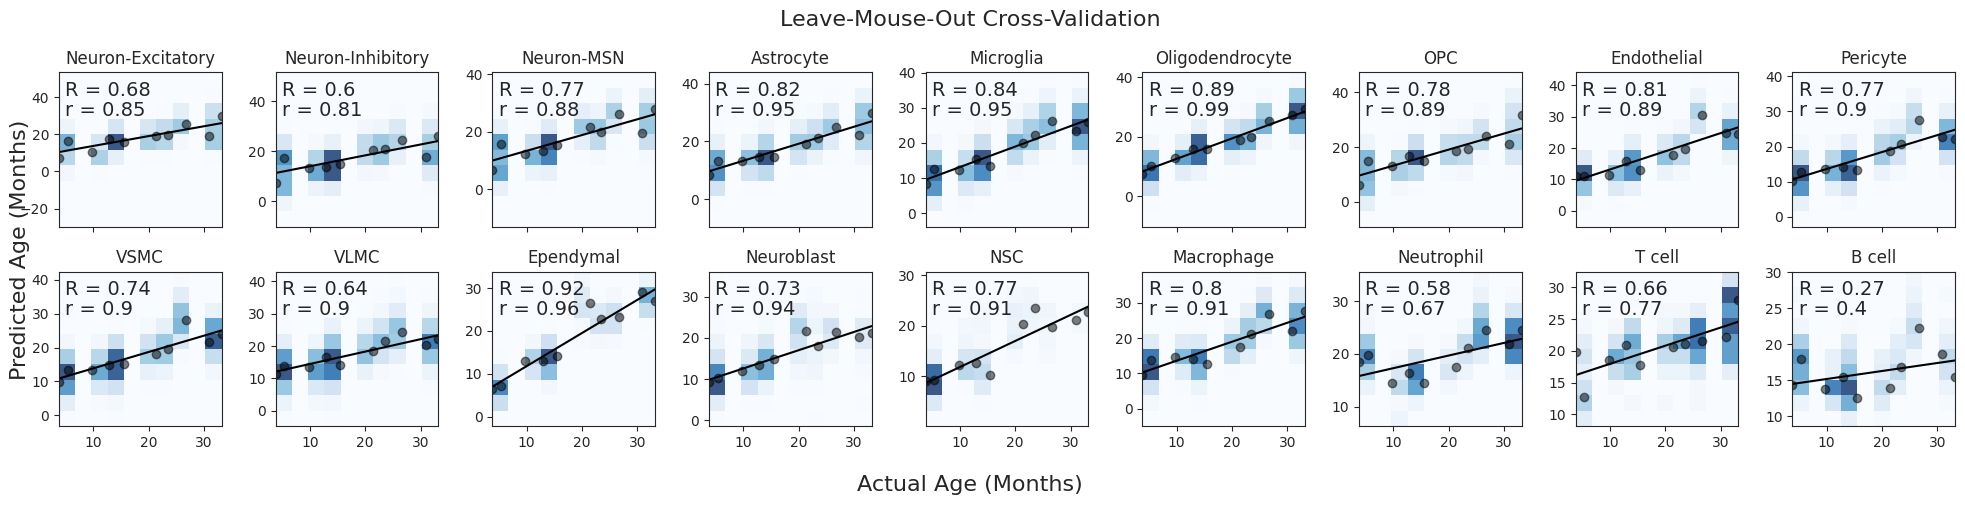

In [11]:
adata = sc.read_h5ad("results/clocks/anndata/batchA_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")
#--------------------------------

nrows = 2
ncols = 9

fig, axs = plt.subplots(2, 9, figsize=(20,5), sharex=True, sharey=False)

celltype_list = []
r_list = []
r_list_median = []
mae_list = []

counter = 0
for i in range(nrows):
    for j in range(ncols):
        
        celltype = list(pd.unique(adata.obs.celltype).sort_values())[counter]
        sub_adata = adata[adata.obs["celltype"]==celltype,:]
        
        # make plot
        axs[i,j].hist2d(sub_adata.obs['age'], sub_adata.obs['predicted_age'], alpha=0.8, cmap='Blues', bins=10)
        axs[i,j].scatter(sub_adata.obs.groupby(["mouse_id"])["age"].median(), sub_adata.obs.groupby(["mouse_id"])["predicted_age"].median(), c='k', alpha=0.5)
        b, a = np.polyfit(sub_adata.obs.groupby(["mouse_id"])["age"].median(), sub_adata.obs.groupby(["mouse_id"])["predicted_age"].median(), deg=1)
        xseq = np.linspace(np.min(sub_adata.obs['age']),np.max(sub_adata.obs['age']),100)
        axs[i,j].plot(xseq, a + b * xseq, color="k")
        axs[i,j].set_title(celltype)
        r,p = pearsonr(sub_adata.obs['age'], sub_adata.obs['predicted_age'])
        r_med,p_med = pearsonr(sub_adata.obs.groupby(["mouse_id"])["age"].median(), sub_adata.obs.groupby(["mouse_id"])["predicted_age"].median())
        mae = np.mean(np.abs(sub_adata.obs['age']-sub_adata.obs['predicted_age']))
        #axs[i,j].annotate(f"R = {round(r,2)}", (0.3, 0.05), xycoords='axes fraction', fontsize=14)
        axs[i,j].annotate(f"R = {round(r,2)}", (0.04, 0.85), xycoords='axes fraction', fontsize=14)
        axs[i,j].annotate(f"r = {round(r_med,2)}", (0.04, 0.72), xycoords='axes fraction', fontsize=14)
        
        # append stats
        celltype_list.append(celltype)
        r_list.append(r)
        mae_list.append(mae)
        r_list_median.append(r_med)
        
        counter += 1

# make figure
fig.suptitle("Leave-Mouse-Out Cross-Validation", fontsize=16)
fig.supxlabel("Actual Age (Months)", fontsize=16)
fig.supylabel("Predicted Age (Months)", fontsize=16)
fig.tight_layout()
plt.savefig(f"plots/clocks/pseudobulked/batchA_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth.pdf",
            bbox_inches='tight')
plt.show()


# save stats
stat_df = pd.DataFrame(np.vstack([celltype_list, r_list, r_list_median, mae_list]).T, columns=["celltype", "pearson", "pearson_median", "mean_abs_err"])
stat_df.to_csv("results/clocks/stats/batchA_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.csv", index=False)

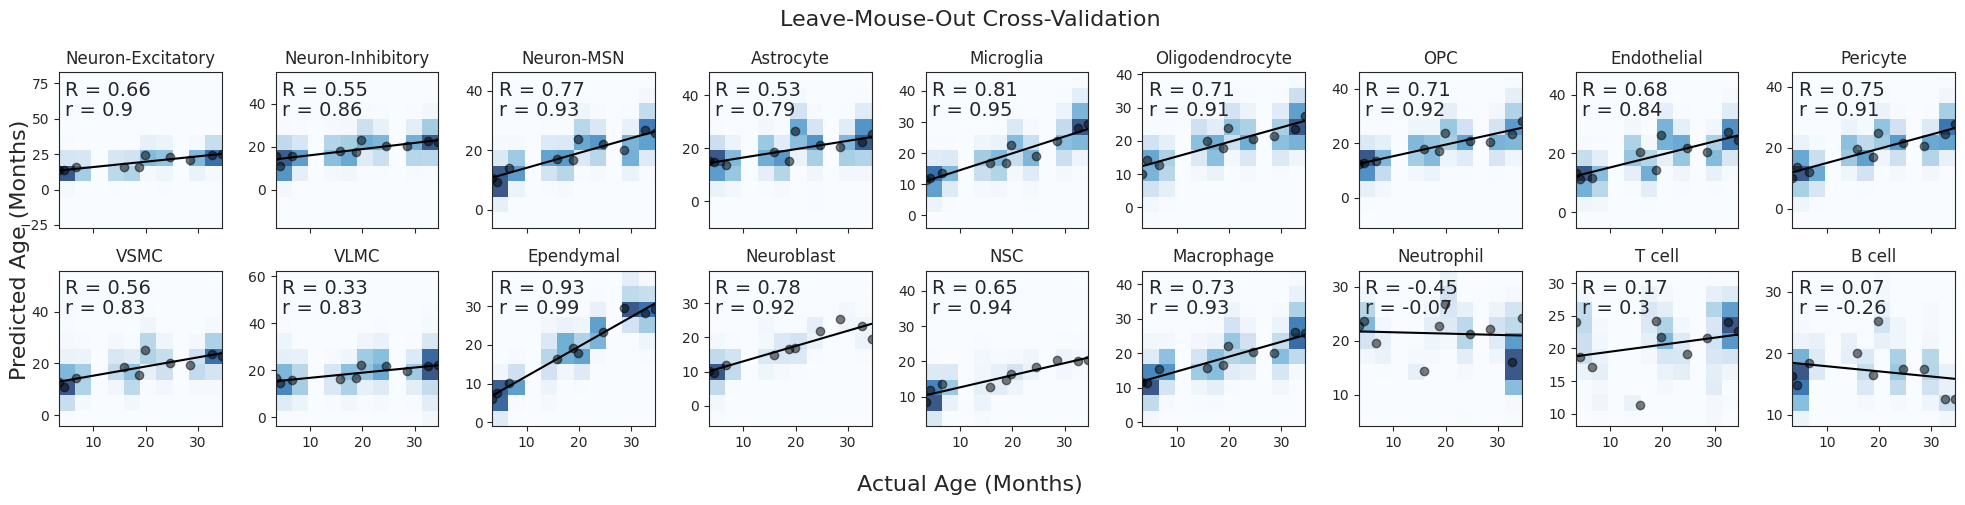

In [12]:
adata = sc.read_h5ad("results/clocks/anndata/batchB_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")
#--------------------------------

nrows = 2
ncols = 9

fig, axs = plt.subplots(2, 9, figsize=(20,5), sharex=True, sharey=False)

celltype_list = []
r_list = []
r_list_median = []
mae_list = []

counter = 0
for i in range(nrows):
    for j in range(ncols):
        
        celltype = list(pd.unique(adata.obs.celltype).sort_values())[counter]
        sub_adata = adata[adata.obs["celltype"]==celltype,:]
        
        # make plot
        axs[i,j].hist2d(sub_adata.obs['age'], sub_adata.obs['predicted_age'], alpha=0.8, cmap='Blues', bins=10)
        axs[i,j].scatter(sub_adata.obs.groupby(["mouse_id"])["age"].median(), sub_adata.obs.groupby(["mouse_id"])["predicted_age"].median(), c='k', alpha=0.5)
        b, a = np.polyfit(sub_adata.obs.groupby(["mouse_id"])["age"].median(), sub_adata.obs.groupby(["mouse_id"])["predicted_age"].median(), deg=1)
        xseq = np.linspace(np.min(sub_adata.obs['age']),np.max(sub_adata.obs['age']),100)
        axs[i,j].plot(xseq, a + b * xseq, color="k")
        axs[i,j].set_title(celltype)
        r,p = pearsonr(sub_adata.obs['age'], sub_adata.obs['predicted_age'])
        r_med,p_med = pearsonr(sub_adata.obs.groupby(["mouse_id"])["age"].median(), sub_adata.obs.groupby(["mouse_id"])["predicted_age"].median())
        mae = np.mean(np.abs(sub_adata.obs['age']-sub_adata.obs['predicted_age']))
        #axs[i,j].annotate(f"R = {round(r,2)}", (0.3, 0.05), xycoords='axes fraction', fontsize=14)
        axs[i,j].annotate(f"R = {round(r,2)}", (0.04, 0.85), xycoords='axes fraction', fontsize=14)
        axs[i,j].annotate(f"r = {round(r_med,2)}", (0.04, 0.72), xycoords='axes fraction', fontsize=14)
        
        # append stats
        celltype_list.append(celltype)
        r_list.append(r)
        mae_list.append(mae)
        r_list_median.append(r_med)
        
        counter += 1

# make figure
fig.suptitle("Leave-Mouse-Out Cross-Validation", fontsize=16)
fig.supxlabel("Actual Age (Months)", fontsize=16)
fig.supylabel("Predicted Age (Months)", fontsize=16)
fig.tight_layout()
plt.savefig(f"plots/clocks/pseudobulked/batchB_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth.pdf",
            bbox_inches='tight')
plt.show()


# save stats
stat_df = pd.DataFrame(np.vstack([celltype_list, r_list, r_list_median, mae_list]).T, columns=["celltype", "pearson", "pearson_median", "mean_abs_err"])
stat_df.to_csv("results/clocks/stats/batchB_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.csv", index=False)

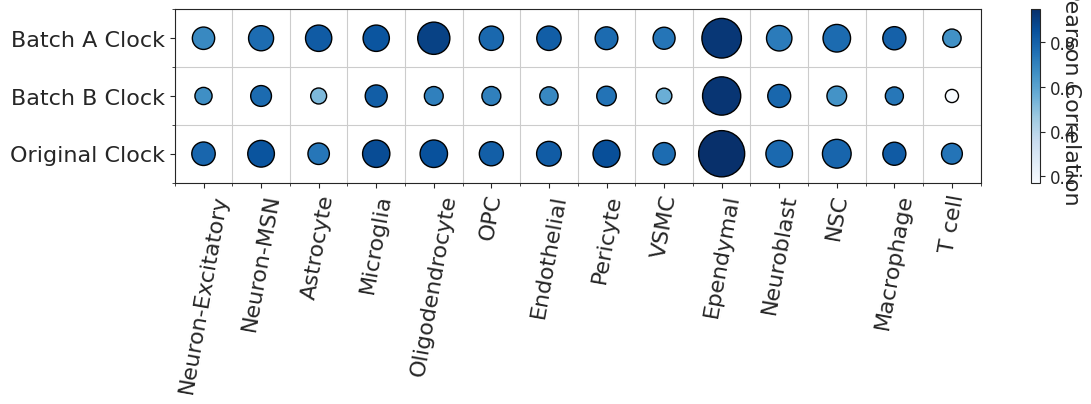

In [14]:
filepaths = ["results/clocks/stats/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.csv",
             "results/clocks/stats/batchB_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.csv",
             "results/clocks/stats/batchA_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.csv"]
names = ["Original Clock", "Batch B Clock", "Batch A Clock"]

celltypes = restricted_celltype_subset

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

###############################################
df_list = []

for i, filepath in enumerate(filepaths):
    df = pd.read_csv(filepath)
    df["name"] = names[i]
    df["celltype"] = df["celltype"].astype('category').cat.reorder_categories(celltypes_full)
    df = df.sort_values(by="celltype")
    df = df[df["celltype"].isin(celltypes)]
    if list(df["celltype"]) != celltypes:
        print("Warning: celltype order not matching up for "+filepath)
    df_list.append(df)
    
comb_df = pd.concat(df_list)

##### code from: https://stackoverflow.com/questions/59381273/heatmap-with-circles-indicating-size-of-population
N = len(filepaths)
M = len(celltypes)
ylabels = names
xlabels = celltypes

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = 1/comb_df["mean_abs_err"].values
c = comb_df["pearson"].values

fig, ax = plt.subplots(figsize=(13,2.25))

R = s/s.max()/2.5 # fixes max radius of circles with this scaling
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="Blues",edgecolor='black',linewidth=1)
ax.add_collection(col)

ax.set_xticks(np.arange(M))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(xlabels, rotation=80, fontsize=16)
ax.set_yticklabels(ylabels, fontsize=16)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(which='minor')

cbar = fig.colorbar(col)
cbar.ax.set_ylabel('Pearson Correlation', rotation=270, fontsize=16)
cbar.ax.tick_params(labelsize=12)


plt.savefig("plots/clocks/comparison_batch_separated_clocks.pdf", bbox_inches='tight')
plt.show()

Checking for generalization of batch-specific clocks across batches.

### Batch A on Batch B

In [6]:
# Batch A clocks on Batch B data
adata = sc.read_h5ad("data/integrated_aging_coronal_celltyped_regioned_raw.h5ad")
adata = adata[adata.obs.batch == "B"].copy()

In [7]:
name = "batchA_lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name)

Astrocyte
B cell
Endothelial
Ependymal
Macrophage
Microglia
NSC
Neuroblast
Neuron-Excitatory
Neuron-Inhibitory
Neuron-MSN
Neutrophil
OPC
Oligodendrocyte
Pericyte
T cell
VLMC
VSMC


In [8]:
# df.to_csv(f"results/clocks/applied/batchAonB_spatialsmooth.csv")
# adata.write_h5ad("results/clocks/anndata/batchAonB_spatialsmooth.h5ad")

In [9]:
ordered_celltypes = ['Neuron-Excitatory','Neuron-Inhibitory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','VLMC','Ependymal','Neuroblast','NSC','Macrophage','Neutrophil','T cell','B cell']

df = pd.read_csv(f"results/clocks/applied/batchAonB_spatialsmooth.csv")
df = df[df['celltype'].isin(ordered_celltypes)]
df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in ordered_celltypes if x in df['celltype'].values])
df = df.sort_values(by="celltype")

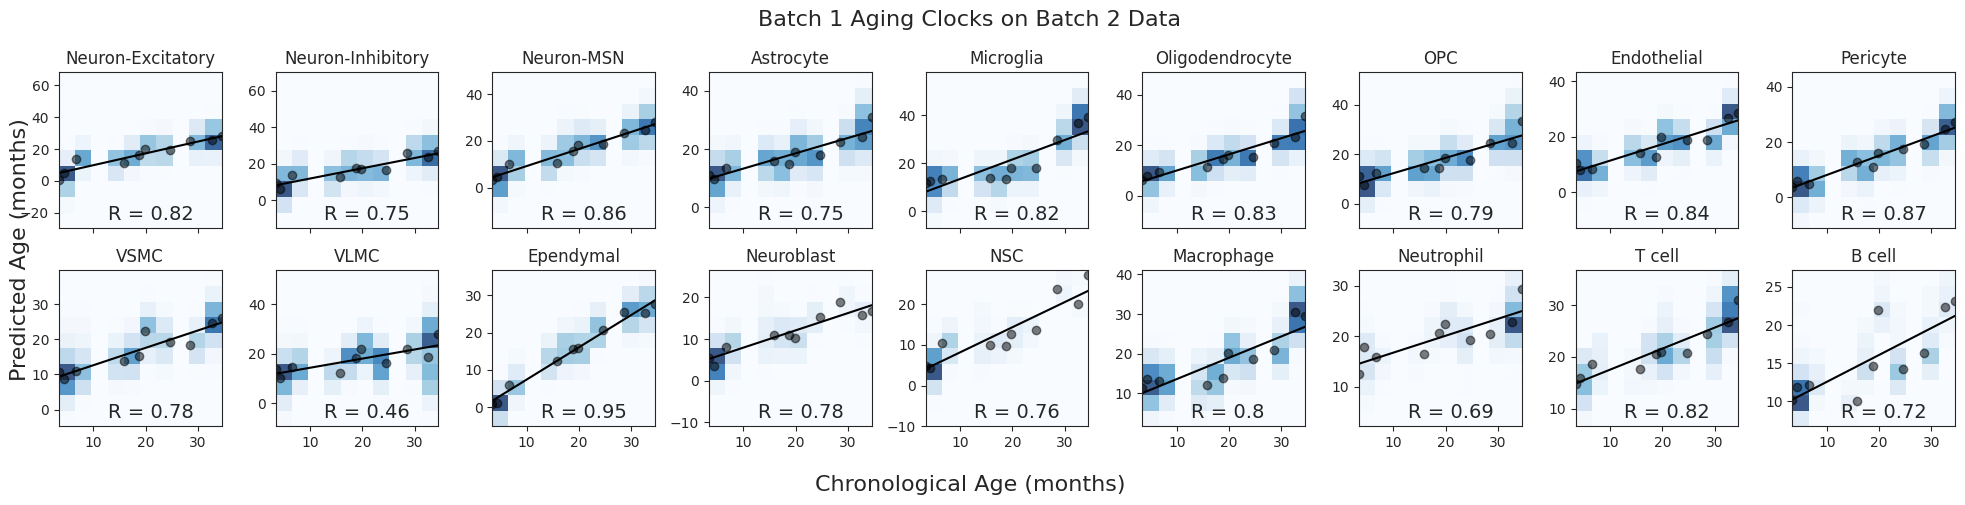

In [10]:
nrows = 2
ncols = 9

fig, axs = plt.subplots(2, 9, figsize=(20,5), sharex=True, sharey=False)

celltype_list = []
r_list = []
mae_list = []

counter = 0
for i in range(nrows):
    for j in range(ncols):
        
        celltype = pd.unique(df.celltype)[counter]
        sub_adata = df[df["celltype"]==celltype].copy()
        sub_adata["age"] = sub_adata["age"].astype(float).values
        sub_adata["pred_age"] = sub_adata["pred_age"].astype(float).values
        
        # make plot
        axs[i,j].hist2d(sub_adata['age'], sub_adata['pred_age'], alpha=0.8, cmap='Blues', bins=10)
        axs[i,j].scatter(sub_adata.groupby(["age"])["age"].median(), sub_adata.groupby(["age"])["pred_age"].median(), c='k', alpha=0.5)
        b, a = np.polyfit(sub_adata.groupby(["age"])["age"].median(), sub_adata.groupby(["age"])["pred_age"].median(), deg=1)
        xseq = np.linspace(np.min(sub_adata['age']),np.max(sub_adata['age']),100)
        axs[i,j].plot(xseq, a + b * xseq, color="k")
        axs[i,j].set_title(celltype)
        r,p = pearsonr(sub_adata['age'], sub_adata['pred_age'])
        mae = np.mean(np.abs(sub_adata['age']-sub_adata['pred_age']))
        axs[i,j].annotate(f"R = {round(r,2)}", (0.3, 0.05), xycoords='axes fraction', fontsize=14)
        
        # append stats
        celltype_list.append(celltype)
        r_list.append(r)
        mae_list.append(mae)
        
        counter += 1

# make figure
fig.suptitle("Batch 1 Aging Clocks on Batch 2 Data", fontsize=16)
fig.supxlabel("Chronological Age (months)", fontsize=16)
fig.supylabel("Predicted Age (months)", fontsize=16)
fig.tight_layout()
plt.savefig(f"plots/clocks/pseudobulked/{name}_onbatchB.pdf",
            bbox_inches='tight')
plt.show()

### Batch B on Batch A

In [11]:
# Batch B clocks on Batch A data
adata = sc.read_h5ad("data/integrated_aging_coronal_celltyped_regioned_raw.h5ad")
adata = adata[adata.obs.batch == "A"].copy()

In [12]:
name = "batchB_lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name)

Astrocyte
B cell
Endothelial
Ependymal
Macrophage
Microglia
NSC
Neuroblast
Neuron-Excitatory
Neuron-Inhibitory
Neuron-MSN
Neutrophil
OPC
Oligodendrocyte
Pericyte
T cell
VLMC
VSMC


In [13]:
# df.to_csv(f"results/clocks/applied/batchBonA_spatialsmooth.csv")
# adata.write_h5ad("results/clocks/anndata/batchBonA_spatialsmooth.h5ad")

In [14]:
ordered_celltypes = ['Neuron-Excitatory','Neuron-Inhibitory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','VLMC','Ependymal','Neuroblast','NSC','Macrophage','Neutrophil','T cell','B cell']

df = pd.read_csv(f"results/clocks/applied/batchBonA_spatialsmooth.csv")
df = df[df['celltype'].isin(ordered_celltypes)]
df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in ordered_celltypes if x in df['celltype'].values])
df = df.sort_values(by="celltype")

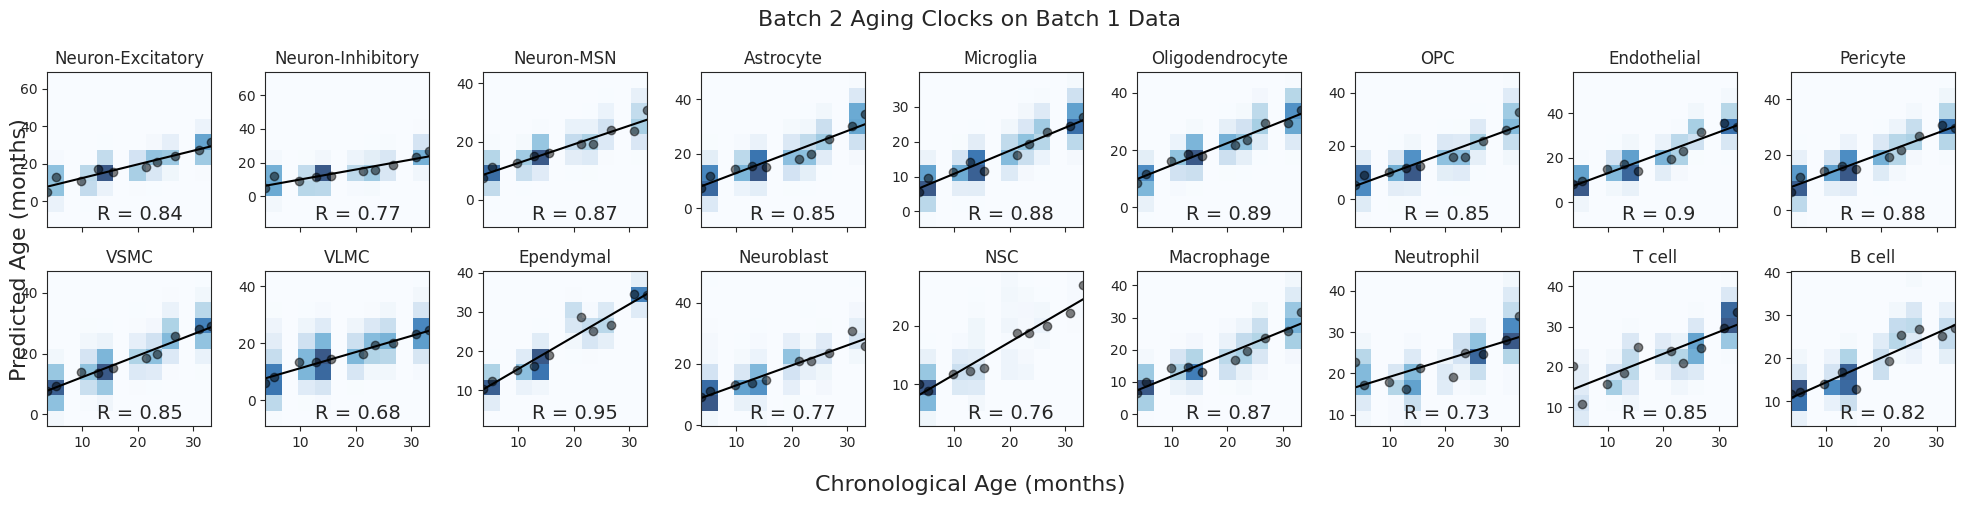

In [15]:
nrows = 2
ncols = 9

fig, axs = plt.subplots(2, 9, figsize=(20,5), sharex=True, sharey=False)

celltype_list = []
r_list = []
mae_list = []

counter = 0
for i in range(nrows):
    for j in range(ncols):
        
        celltype = pd.unique(df.celltype)[counter]
        sub_adata = df[df["celltype"]==celltype].copy()
        sub_adata["age"] = sub_adata["age"].astype(float).values
        sub_adata["pred_age"] = sub_adata["pred_age"].astype(float).values
        
        # make plot
        axs[i,j].hist2d(sub_adata['age'], sub_adata['pred_age'], alpha=0.8, cmap='Blues', bins=10)
        axs[i,j].scatter(sub_adata.groupby(["age"])["age"].median(), sub_adata.groupby(["age"])["pred_age"].median(), c='k', alpha=0.5)
        b, a = np.polyfit(sub_adata.groupby(["age"])["age"].median(), sub_adata.groupby(["age"])["pred_age"].median(), deg=1)
        xseq = np.linspace(np.min(sub_adata['age']),np.max(sub_adata['age']),100)
        axs[i,j].plot(xseq, a + b * xseq, color="k")
        axs[i,j].set_title(celltype)
        r,p = pearsonr(sub_adata['age'], sub_adata['pred_age'])
        mae = np.mean(np.abs(sub_adata['age']-sub_adata['pred_age']))
        axs[i,j].annotate(f"R = {round(r,2)}", (0.3, 0.05), xycoords='axes fraction', fontsize=14)
        
        # append stats
        celltype_list.append(celltype)
        r_list.append(r)
        mae_list.append(mae)
        
        counter += 1

# make figure
fig.suptitle("Batch 2 Aging Clocks on Batch 1 Data", fontsize=16)
fig.supxlabel("Chronological Age (months)", fontsize=16)
fig.supylabel("Predicted Age (months)", fontsize=16)
fig.tight_layout()
plt.savefig(f"plots/clocks/pseudobulked/{name}_onbatchA.pdf",
            bbox_inches='tight')
plt.show()

### Correlation in predicted age across batch-separated and main (combined) clocks

In [5]:
# Read in batched predictions
adata_batched = ad.concat((sc.read_h5ad("results/clocks/anndata/batchBonA_spatialsmooth.h5ad"),
                  sc.read_h5ad("results/clocks/anndata/batchAonB_spatialsmooth.h5ad")))

metadata_batched = adata_batched.obs.copy()
del adata_batched
import gc
gc.collect()

# Read in original predictions
adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")

metadata = adata.obs.copy()
del adata
import gc
gc.collect()

132

In [7]:
metadata_batched = metadata_batched.reindex(metadata.index)

In [9]:
metadata["batch_predicted_age"] = metadata_batched["predicted_age"]

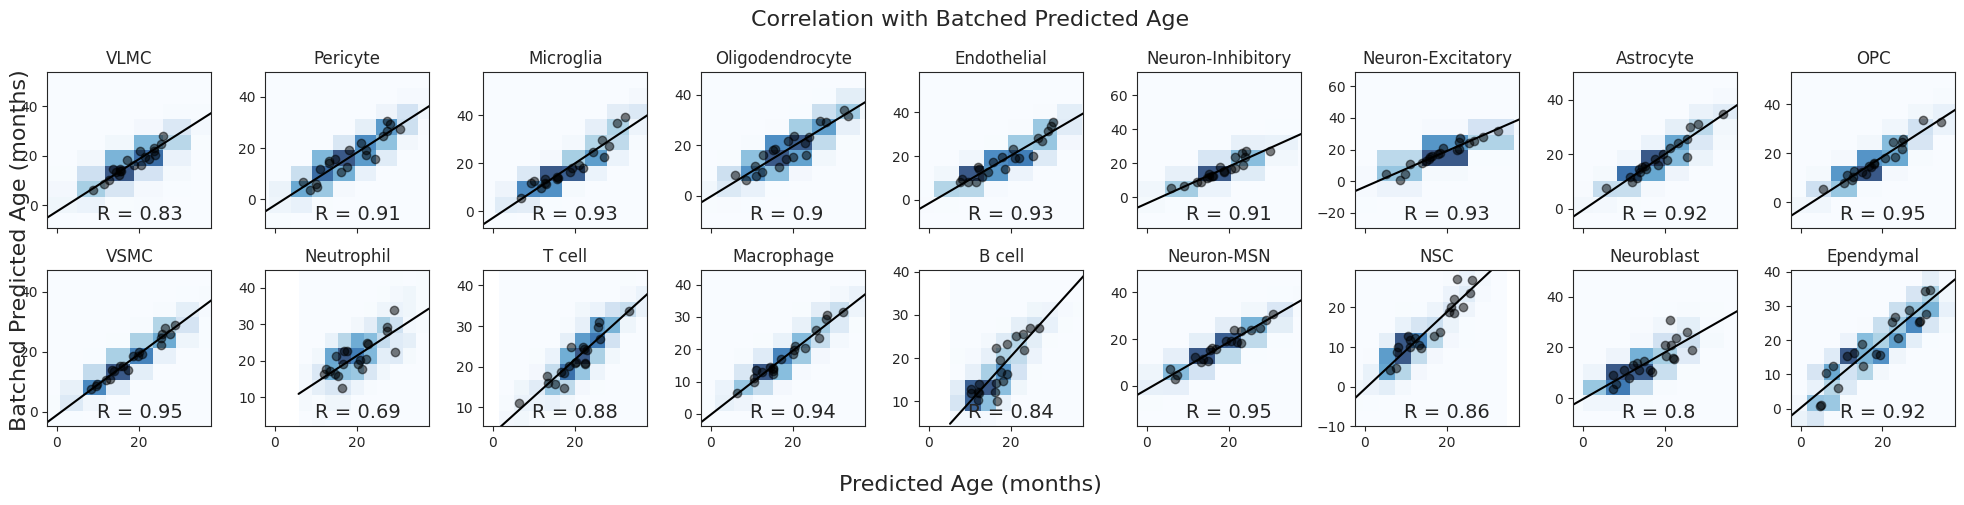

In [13]:
nrows = 2
ncols = 9

fig, axs = plt.subplots(2, 9, figsize=(20,5), sharex=True, sharey=False)

celltype_list = []
r_list = []
mae_list = []


counter = 0
for i in range(nrows):
    for j in range(ncols):
        
        celltype = pd.unique(metadata.celltype)[counter]
        sub_metadata = metadata[metadata["celltype"]==celltype].copy()
        
        # make plot
        axs[i,j].hist2d(sub_metadata['predicted_age'], sub_metadata['batch_predicted_age'], alpha=0.8, cmap='Blues', bins=10)
        axs[i,j].scatter(sub_metadata.groupby(["age"])["predicted_age"].median(), sub_metadata.groupby(["age"])["batch_predicted_age"].median(), c='k', alpha=0.5)
        b, a = np.polyfit(sub_metadata.groupby(["age"])["predicted_age"].median(), sub_metadata.groupby(["age"])["batch_predicted_age"].median(), deg=1)
        xseq = np.linspace(np.min(sub_metadata['predicted_age']),np.max(sub_metadata['predicted_age']),100)
        axs[i,j].plot(xseq, a + b * xseq, color="k")
        axs[i,j].set_title(celltype)
        r,p = pearsonr(sub_metadata['predicted_age'], sub_metadata['batch_predicted_age'])
        mae = np.mean(np.abs(sub_metadata['predicted_age']-sub_metadata['batch_predicted_age']))
        axs[i,j].annotate(f"R = {round(r,2)}", (0.3, 0.05), xycoords='axes fraction', fontsize=14)
        
        # append stats
        celltype_list.append(celltype)
        r_list.append(r)
        mae_list.append(mae)
        
        counter += 1

# make figure
fig.suptitle("Correlation with Batched Predicted Age", fontsize=16)
fig.supxlabel("Predicted Age (months)", fontsize=16)
fig.supylabel("Batched Predicted Age (months)", fontsize=16)
fig.tight_layout()
plt.savefig(f"plots/clocks/pseudobulked/batched_predicted_age_correlation.pdf",
            bbox_inches='tight')
plt.show()

## Rejuvenation and Deleterious intervention effects

### Exercise

In [4]:
adata = sc.read_h5ad("data/integrated_exercise_coronal_celltyped_regioned_raw.h5ad")

In [6]:
name = "batchA_lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name)

df.to_csv(f"results/clocks/applied/batchA_exercise_spatialsmooth.csv")
adata.write_h5ad("results/clocks/anndata/batchA_exercise_spatialsmooth.h5ad")

Astrocyte
B cell
Endothelial
Ependymal
Macrophage
Microglia
NSC
Neuroblast
Neuron-Excitatory
Neuron-Inhibitory
Neuron-MSN
Neutrophil
OPC
Oligodendrocyte
Pericyte
T cell
VLMC
VSMC


In [5]:
name = "batchB_lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name)

df.to_csv(f"results/clocks/applied/batchB_exercise_spatialsmooth.csv")
adata.write_h5ad("results/clocks/anndata/batchB_exercise_spatialsmooth.h5ad")

Astrocyte
B cell
Endothelial
Ependymal
Macrophage
Microglia
NSC
Neuroblast
Neuron-Excitatory
Neuron-Inhibitory
Neuron-MSN
Neutrophil
OPC
Oligodendrocyte
Pericyte
T cell
VLMC
VSMC


/local/scratch/edsun/slrmtmp.42818275/ipykernel_9527/806292022.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()


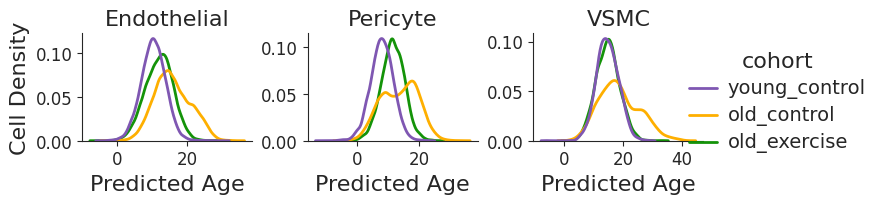

/local/scratch/edsun/slrmtmp.42818275/ipykernel_9527/806292022.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()


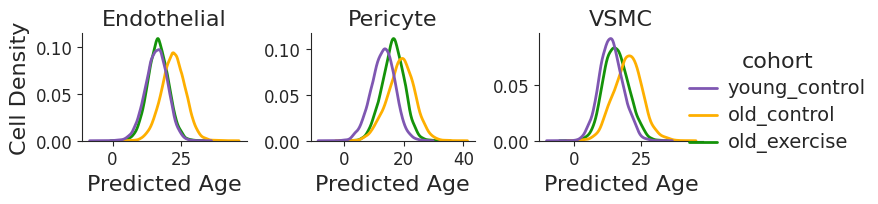

In [7]:
for batch in ["batchA", "batchB"]:
    
    df = pd.read_csv(f"results/clocks/applied/{batch}_exercise_spatialsmooth.csv")
    df = df[df['celltype'].isin(restricted_celltype_subset)]
    df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in df['celltype'].values])
    df = df.sort_values(by="celltype")


    # Plot predicted age densities across select cell types

    palette = {"young_control":"#7F57B2",
               "old_exercise":"#149309",
               "old_control":"#FEAF00"}

    sub_df = df[df["celltype"].isin(["Endothelial","Pericyte","VSMC"])]
    sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()

    ncols = 3

    g = sns.displot(data=sub_df, x="pred_age", hue="cohort", col="celltype", kind="kde", col_wrap=ncols, height=6/ncols, aspect=1.2,
                facet_kws={'sharey': False, 'sharex': False}, palette=palette,
                hue_order=["young_control", "old_control", "old_exercise"], linewidth=2,
                common_norm=False)
    for ax in g.axes.flat:
        ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
        if ax.get_xlabel() != "":
            ax.set_xlabel("Predicted Age", fontsize=16)
        if ax.get_ylabel() != "":
            ax.set_ylabel("Cell Density", fontsize=16)
        ax.tick_params(which='major', labelsize=12)

    g.legend.get_title().set_size(16)
    for label in g.legend.get_texts():
        label.set_size(14)

    plt.savefig(f"plots/exercise/{batch}_exercise_spatialsmooth.pdf", bbox_inches='tight')
    plt.show()

### Partial reprogramming

In [8]:
adata = sc.read_h5ad("data/integrated_reprogramming_coronal_celltyped_regioned_raw.h5ad")

In [9]:
name = "batchA_lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name)

df.to_csv(f"results/clocks/applied/batchA_reprogramming_spatialsmooth.csv")
adata.write_h5ad("results/clocks/anndata/batchA_reprogramming_spatialsmooth.h5ad")

Astrocyte
Endothelial
Ependymal
Macrophage
Microglia
NSC
Neuroblast
Neuron-Excitatory
Neuron-Inhibitory
Neuron-MSN
OPC
Oligodendrocyte
Pericyte
VLMC
VSMC


In [10]:
name = "batchB_lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name)

df.to_csv(f"results/clocks/applied/batchB_reprogramming_spatialsmooth.csv")
adata.write_h5ad("results/clocks/anndata/batchB_reprogramming_spatialsmooth.h5ad")

Astrocyte
Endothelial
Ependymal
Macrophage
Microglia
NSC
Neuroblast
Neuron-Excitatory
Neuron-Inhibitory
Neuron-MSN
OPC
Oligodendrocyte
Pericyte
VLMC
VSMC


/local/scratch/edsun/slrmtmp.42818275/ipykernel_9527/3470844490.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()


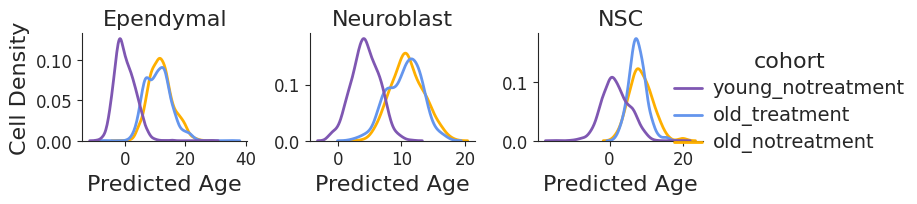

/local/scratch/edsun/slrmtmp.42818275/ipykernel_9527/3470844490.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()


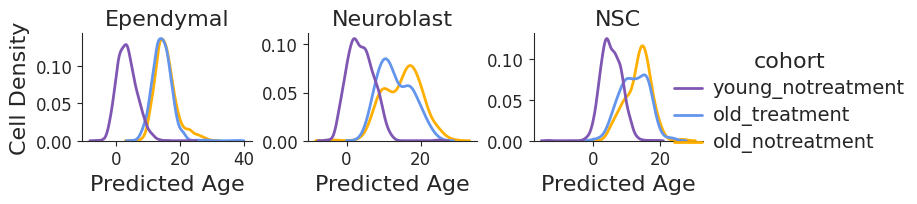

In [11]:
for batch in ["batchA", "batchB"]:
    
    df = pd.read_csv(f"results/clocks/applied/{batch}_reprogramming_spatialsmooth.csv")
    df = df[df['celltype'].isin(restricted_celltype_subset)]
    df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in df['celltype'].values])
    df = df.sort_values(by="celltype")
    
    # correct for difference in ages between treatment and control
    mean_oc_age = np.mean(np.unique(df[df.cohort=="old_notreatment"].age))
    mean_ot_age = np.mean(np.unique(df[df.cohort=="old_treatment"].age))
    pred_ages = df["pred_age"].values.copy()
    pred_ages[df.cohort=="old_notreatment"] += (mean_ot_age-mean_oc_age)
    df["pred_age"] = pred_ages

    palette = {"young_notreatment":"#7F57B2",
               "old_treatment":"cornflowerblue", # #149309
               "old_notreatment":"#FEAF00"}

    sub_df = df[df["celltype"].isin(["Ependymal","Neuroblast","NSC"])]
    sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()

    ncols = 3
    g = sns.displot(data=sub_df, x="pred_age", hue="cohort", col="celltype", kind="kde", col_wrap=ncols, height=6/ncols, aspect=1.2,
                facet_kws={'sharey': False, 'sharex': False}, palette=palette,
                hue_order=["young_notreatment", "old_treatment", "old_notreatment"], linewidth=2,
                common_norm=False)
    for ax in g.axes.flat:
        ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
        if ax.get_xlabel() != "":
            ax.set_xlabel("Predicted Age", fontsize=16)
        if ax.get_ylabel() != "":
            ax.set_ylabel("Cell Density", fontsize=16)
        ax.tick_params(which='major', labelsize=12)

    g.legend.get_title().set_size(16)
    for label in g.legend.get_texts():
        label.set_size(14)

    plt.savefig(f"plots/reprogramming/{batch}_reprogramming_spatialsmooth_SUBSET.pdf", bbox_inches='tight')
    plt.show()

### LPS/Inflammation (Allen et al., 2022)

In [12]:
adata = sc.read_h5ad("data/allen_2022_aging_merfish/merfish_combined_processed_umap.h5ad")
adata.obs["region"] = adata.obs.tissue.copy()

In [14]:
name = "batchA_lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name, normalize=False, standardize=False, fill_missing="spage")

df.to_csv(f"results/clocks/applied/batchA_allen_aging_lps_spatialsmooth_spage.csv")
adata.write_h5ad("results/clocks/anndata/batchA_allen_aging_lps_spatialsmooth_spage.h5ad")

Astrocyte
Imputing values for 225 missing genes
Endothelial
Imputing values for 225 missing genes
Macrophage
Imputing values for 225 missing genes
Microglia
Imputing values for 225 missing genes
Neuron-Excitatory
Imputing values for 225 missing genes
Neuron-Inhibitory
Imputing values for 225 missing genes
Neuron-MSN
Imputing values for 225 missing genes
OPC
Imputing values for 225 missing genes
Oligodendrocyte
Imputing values for 225 missing genes
Pericyte
Imputing values for 225 missing genes
T cell
Imputing values for 225 missing genes
VLMC
Imputing values for 225 missing genes


In [13]:
name = "batchB_lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name, normalize=False, standardize=False, fill_missing="spage")

df.to_csv(f"results/clocks/applied/batchB_allen_aging_lps_spatialsmooth_spage.csv")
adata.write_h5ad("results/clocks/anndata/batchB_allen_aging_lps_spatialsmooth_spage.h5ad")

Astrocyte
Imputing values for 225 missing genes
Endothelial
Imputing values for 225 missing genes
Macrophage
Imputing values for 225 missing genes
Microglia
Imputing values for 225 missing genes
Neuron-Excitatory
Imputing values for 225 missing genes
Neuron-Inhibitory
Imputing values for 225 missing genes
Neuron-MSN
Imputing values for 225 missing genes
OPC
Imputing values for 225 missing genes
Oligodendrocyte
Imputing values for 225 missing genes
Pericyte
Imputing values for 225 missing genes
T cell
Imputing values for 225 missing genes
VLMC
Imputing values for 225 missing genes


/local/scratch/edsun/slrmtmp.42818275/ipykernel_9527/2799381310.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()


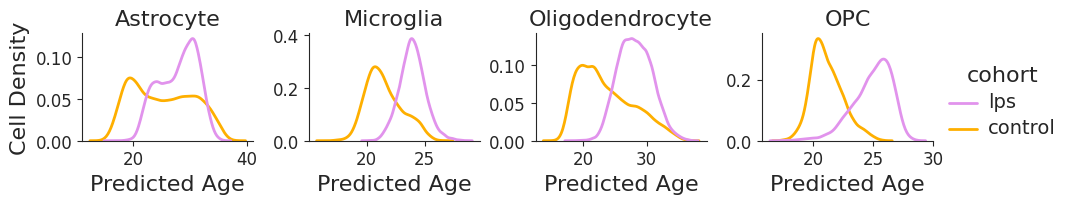

/local/scratch/edsun/slrmtmp.42818275/ipykernel_9527/2799381310.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()


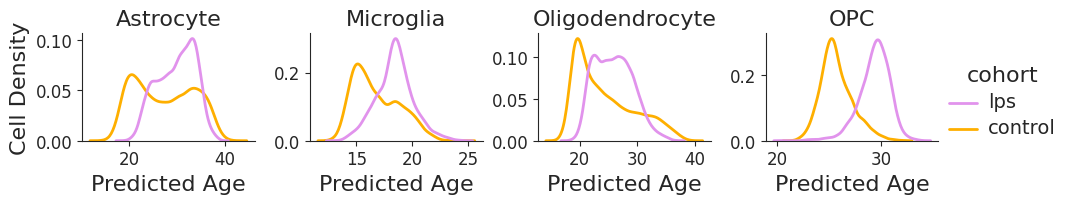

In [15]:
for batch in ["batchA", "batchB"]:
    
    df = pd.read_csv(f"results/clocks/applied/{batch}_allen_aging_lps_spatialsmooth_spage.csv")
    df = df[df['celltype'].isin(restricted_celltype_subset)]
    df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in df['celltype'].values])
    df = df.sort_values(by="celltype")

    sub_df = df[df["celltype"].isin(["Astrocyte","Microglia","Oligodendrocyte","OPC"])]
    sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()

    age=20.93

    df_lps = sub_df[sub_df['age']==age].copy()
    df_lps = df_lps.replace('aging', 'control')

    palette = {"control":"#FEAF00",
           "lps":"#E193EC"} # #E193EC

    ncols = 4
    g = sns.displot(data=df_lps[df_lps['age']==age], x="pred_age", hue="cohort", col="celltype", kind="kde", col_wrap=ncols, height=2, aspect=1.2,
                facet_kws={'sharey': False, 'sharex': False}, palette=palette,
                linewidth=2, common_norm=False)
    for ax in g.axes.flat:
        ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
        if ax.get_xlabel() != "":
            ax.set_xlabel("Predicted Age", fontsize=16)
        if ax.get_ylabel() != "":
            ax.set_ylabel("Cell Density", fontsize=16)
        ax.tick_params(which='major', labelsize=12)

    g.legend.get_title().set_size(16)
    for label in g.legend.get_texts():
        label.set_size(14)

    plt.savefig(f"plots/clocks/{batch}_allen_lps{round(float(age))}_spatialsmooth_spage_SUBSET.pdf")
    plt.show()

### Alzheimer's Disease (Zeng et al., 2023)

In [16]:
adata = sc.read_h5ad("data/zeng_2023_alzheimer_starmap/starmap_AD_processed.h5ad")
adata.obsm['spatial'] = adata.obs[["X","Y"]].values
adata.obs["region"] = adata.obs.region_merged.copy()

In [17]:
name = "batchA_lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name, fill_missing="spage")

df.to_csv(f"results/clocks/applied/batchA_zeng_starmapAD_spatialsmooth_spage.csv")
adata.write_h5ad("results/clocks/anndata/batchA_zeng_starmapAD_spatialsmooth_spage.h5ad")

Astrocyte


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 128 missing genes
Endothelial


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 128 missing genes
Microglia


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 128 missing genes
Neuron-Excitatory


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 128 missing genes
Neuron-Inhibitory


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 128 missing genes
OPC


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 128 missing genes
Oligodendrocyte


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 128 missing genes
VSMC


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 128 missing genes


In [18]:
name = "batchB_lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name, fill_missing="spage")

df.to_csv(f"results/clocks/applied/batchB_zeng_starmapAD_spatialsmooth_spage.csv")
adata.write_h5ad("results/clocks/anndata/batchB_zeng_starmapAD_spatialsmooth_spage.h5ad")

Astrocyte


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 128 missing genes
Endothelial


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 128 missing genes
Microglia


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 128 missing genes
Neuron-Excitatory


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 128 missing genes
Neuron-Inhibitory


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 128 missing genes
OPC


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 128 missing genes
Oligodendrocyte


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 128 missing genes
VSMC


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 128 missing genes


/local/scratch/edsun/slrmtmp.42818275/ipykernel_9527/2810828035.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()


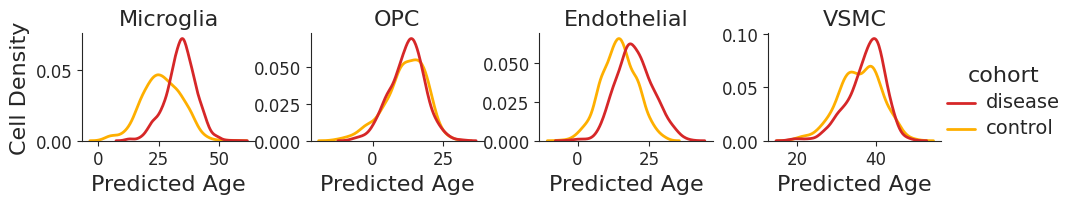

/local/scratch/edsun/slrmtmp.42818275/ipykernel_9527/2810828035.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()


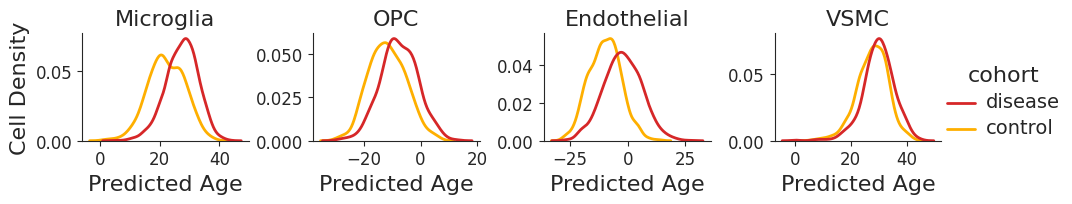

In [19]:
for batch in ["batchA", "batchB"]:
    
    df = pd.read_csv(f"results/clocks/applied/{batch}_zeng_starmapAD_spatialsmooth_spage.csv")
    df = df[df['celltype'].isin(restricted_celltype_subset)]
    df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in df['celltype'].values])
    df = df.sort_values(by="celltype")
    

    sub_df = df[df["celltype"].isin(["Microglia","OPC","Endothelial","VSMC"])]
    sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()

    palette = {"control":"#FEAF00", # #935E09
               "disease":"tab:red"}
    ncols = 4
    g = sns.displot(data=sub_df[sub_df['age']==13], x="pred_age", hue="cohort", col="celltype", kind="kde", col_wrap=ncols, height=2, aspect=1.2,
                facet_kws={'sharey': False, 'sharex': False}, palette=palette,
                linewidth=2, common_norm=False)
    for ax in g.axes.flat:
        ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
        if ax.get_xlabel() != "":
            ax.set_xlabel("Predicted Age", fontsize=16)
        if ax.get_ylabel() != "":
            ax.set_ylabel("Cell Density", fontsize=16)
        ax.tick_params(which='major', labelsize=12)

    g.legend.get_title().set_size(16)
    for label in g.legend.get_texts():
        label.set_size(14)

    plt.savefig(f"plots/clocks/{batch}_zeng_spatialsmooth_spage_13mo_SUBSET.pdf", bbox_inches='tight')
    plt.show()

## Cell Proximity Effects

In [15]:
# Distance Cutoff Parameters -- see D1_regional_proximity_distance_cutoffs.ipynb

cutoff_dict = {
    "A": {'CC/ACO': 24.883324965922327, 'CTX_L1/MEN': 25.151994581290072, 'CTX_L2/3': 24.8986954554853, 'CTX_L4/5/6': 26.897867900910036, 'STR_CP/ACB': 21.57468758003645, 'STR_LS/NDB': 20.153311051666787, 'VEN': 17.5306885003153},
    "B": {'CC/ACO': 24.892495225940742, 'CTX_L1/MEN': 26.676511032192884, 'CTX_L2/3': 23.1942910394144, 'CTX_L4/5/6': 27.59011210228698, 'STR_CP/ACB': 21.725140669814948, 'STR_LS/NDB': 20.557061340809884, 'VEN': 18.195619304468245},
}

/oak/stanford/scg/lab_abrunet1/Eric/MERFISH/ageaccel_proximity.py:199: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t,p = ttest_ind(adata.obs['normalized_age_acceleration'].copy()[near_ages=="Near"],
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in true_divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/oak/stanford/scg/lab_abrunet1/Eric/MERFISH/ageaccel_proximity.py:199: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unre

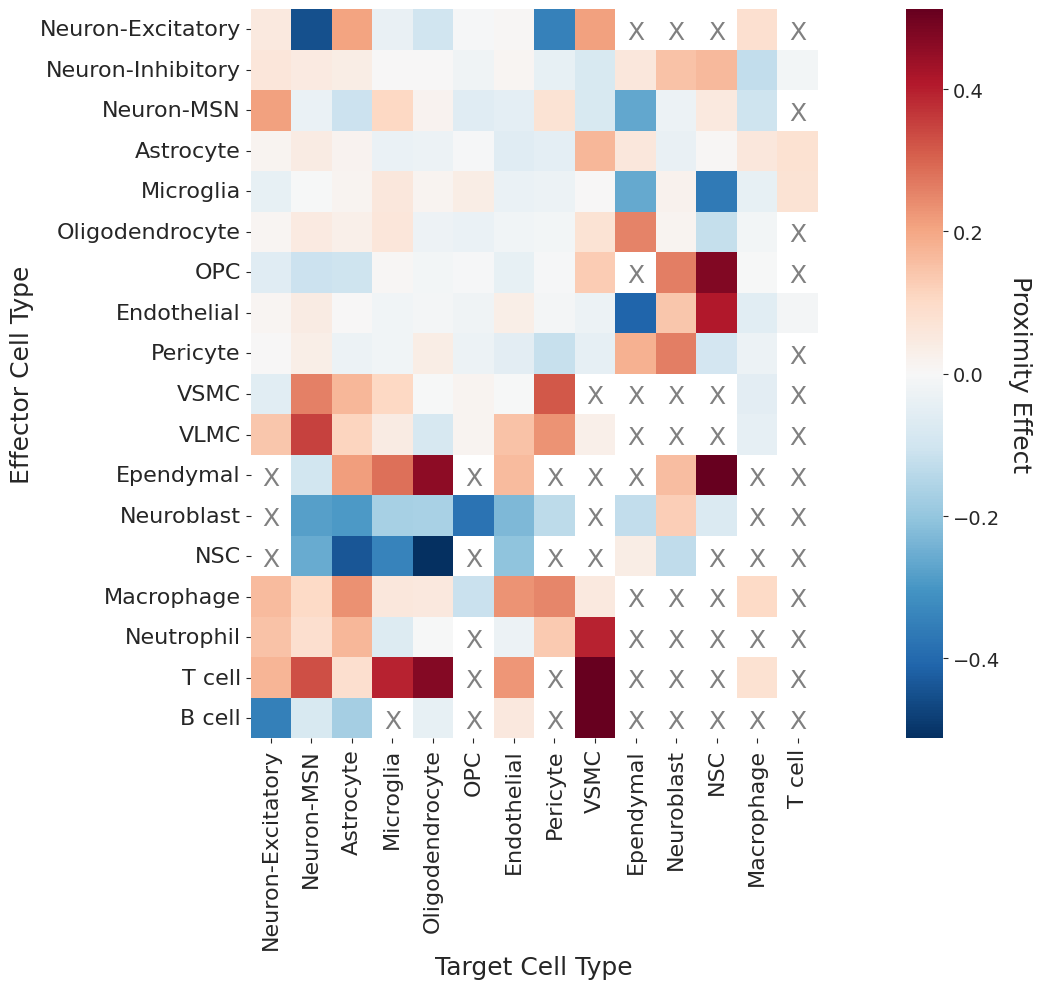

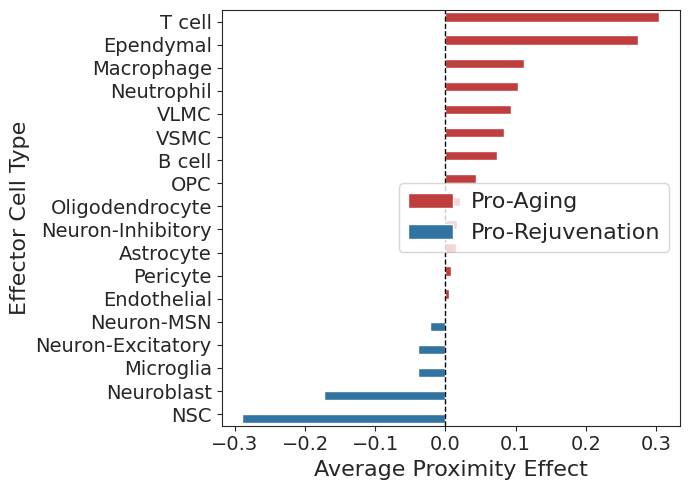

/oak/stanford/scg/lab_abrunet1/Eric/MERFISH/ageaccel_proximity.py:199: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t,p = ttest_ind(adata.obs['normalized_age_acceleration'].copy()[near_ages=="Near"],
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in true_divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/local/scratch/edsun/slrmtmp.42820027/ipykernel_49126/1525245889.py:57: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = comb_df_sub.pivot("Near Cell", "AgeAccel Cell", "

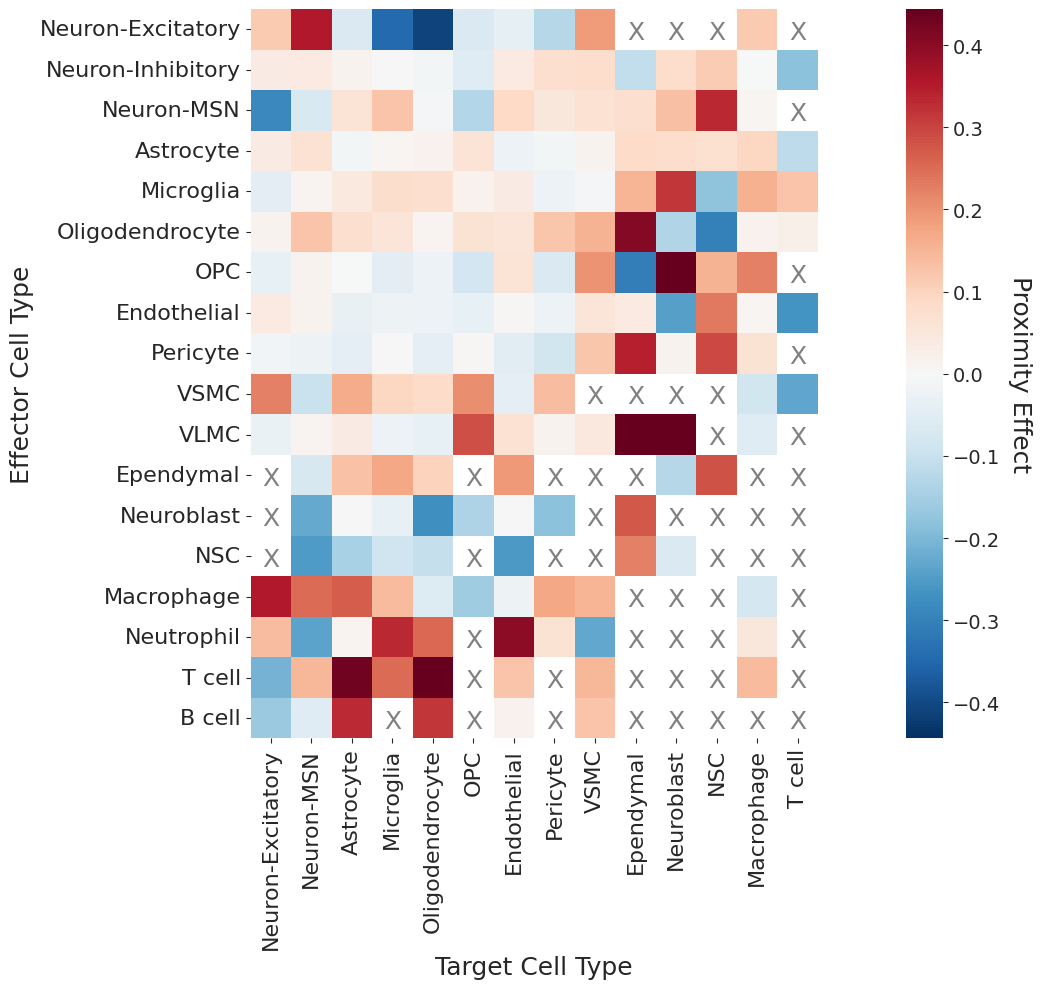

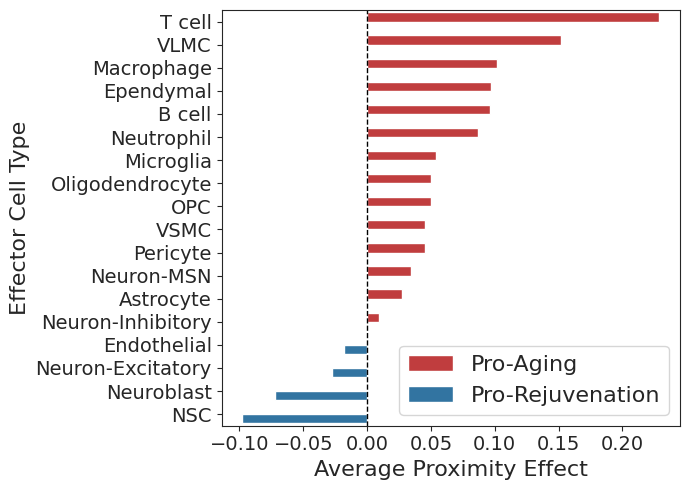

In [17]:
for batch in ["A", "B"]:
    
    cutoff = cutoff_dict[batch]

    adata = sc.read_h5ad(f"results/clocks/anndata/batch{batch}_lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")


    # compute age acceleration
    get_age_acceleration (adata)

    # Compute nearest to cell type distances
    nearest_distance_to_celltype(adata,
                                 celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                                 sub_id="mouse_id")

    # Compute proximity stats

    cutoff_multiplier = 1

    celltypes = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                        'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                        'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                        'Ependymal', 'Neuroblast', 'NSC', 
                        'Macrophage', 'Neutrophil','T cell', 'B cell']
    ###########################
    comb_df = pd.DataFrame([])

    for celltype in celltypes:

        for ct in pd.unique(adata.obs.celltype).sort_values():

            sub_adata = adata[adata.obs["celltype"]==ct]

            # get paired proximity sets
            near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier)

            # run test
            df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct, adata)

            comb_df = pd.concat((comb_df, df))



    #### Heatmap visualization of all proximity effects

    comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()
    comb_df_sub["Near Cell"] = comb_df_sub["Near Cell"].astype('category').cat.reorder_categories([x for x in celltypes_full if x in comb_df_sub['Near Cell'].values])
    comb_df_sub["AgeAccel Cell"] = comb_df_sub["AgeAccel Cell"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in comb_df_sub['AgeAccel Cell'].values])

    pivot_df = comb_df_sub.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")

    fig, ax = plt.subplots(figsize=(18,10))

    # set X mask for NaN values
    sns.heatmap(
        np.where(pivot_df.isna(), 0, np.nan),
        square=True,
        cbar=False,
        annot=np.full_like(pivot_df, "X", dtype=object),
        fmt="",
        annot_kws={"size": 18, "va": "center_baseline", "color": "0.5"},
        cmap=ListedColormap(['none']),
        linewidth=0, ax=ax)

    # make colored heatmap
    sns.heatmap(pivot_df, ax=ax, square=True, cmap="RdBu_r",
                vmin=-np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98),
                vmax=np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98))

    ax.collections[1].colorbar.set_label('Proximity Effect',
                                        rotation=270, fontsize=18, labelpad=23)
    ax.collections[1].colorbar.ax.tick_params(labelsize=14)

    plt.ylabel("Effector Cell Type", fontsize=18)
    plt.xlabel("Target Cell Type", fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.savefig(f"plots/proximity/batch{batch}_celltype_proximity_age_accel_ttest_heatmap_ALL_spatialsmooth_regionmatchedfarthest_cohensd.pdf",
              bbox_inches='tight')
    plt.show()



    #### AVERAGED PLOT


    # subset to only restricted cells among target cell types
    comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()

    # compute average proximity effects for each effector cell and then rank order
    celltypes = []
    average_effects = []
    colors = []

    for ct in np.unique(comb_df_sub["Near Cell"]):
        average_effect = np.nanmean(comb_df_sub[comb_df_sub["Near Cell"]==ct]["Aging Effect"])
        if average_effect > 0:
            color = 'Pro-Aging'
        else:
            color = 'Pro-Rejuvenation'

        celltypes.append(ct)
        average_effects.append(average_effect)
        colors.append(color)

    sort_idxs = np.argsort(average_effects)[::-1]
    celltypes = np.array(celltypes)[sort_idxs]
    colors = np.array(colors)[sort_idxs]
    average_effects = np.array(average_effects)[sort_idxs]


    palette = {"Pro-Aging":"tab:red",
               "Pro-Rejuvenation":"tab:blue"}

    # generate vertical bar plot
    plt.figure(figsize=(7,5))

    g = sns.barplot(
        x=average_effects,
        y=celltypes,
        hue=colors,
        palette=palette,
    )

    plt.axvline(0, color='k', linewidth=1, linestyle="--")

    plt.ylabel("Effector Cell Type", fontsize=16)
    plt.xlabel("Average Proximity Effect", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=16, loc="best")
    plt.tight_layout()
    plt.savefig(f"plots/proximity/batch{batch}_celltype_proximity_age_accel_AVG_horbar_cohensd.pdf",
                bbox_inches='tight')
    plt.show()